# **Lab1: Regression**
In *lab 1*, you need to finish:

1.  Basic Part: Implement the regression model to predict people's grip force from their weight.
You can use either Matrix Inversion or Gradient Descent.


> *   Step 1: Split Data
> *   Step 2: Preprocess Data
> *   Step 3: Implement Regression
> *   Step 4: Make Prediction
> *   Step 5: Train Model and Generate Result

2.  Advanced Part: Implementing a regression model to predict grip force in a different way (for example, with more variables) than the basic part




---
# 1. Basic Part (50%)
In the first part, you need to implement the regression to predict grip force

Please save the prediction result in a CSV file and submit it to Kaggle

### Import Packages

> Note: You **cannot** import any other package


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math
import random

### Global attributes
Define the global attributes\
You can also add your own global attributes here

In [ ]:
training_dataroot = 'lab1_basic_training.csv' # Training data file file named as 'lab1_basic_training.csv'
testing_dataroot = 'lab1_basic_testing.csv'   # Testing data file named as 'lab1_basic_testing.csv'
output_dataroot = 'lab1_basic.csv' # Output file will be named as 'lab1_basic.csv'

training_datalist =  [] # Training datalist, saved as numpy array
testing_datalist =  [] # Testing datalist, saved as numpy array

output_datalist =  [] # Your prediction, should be a list with 100 elements

### Load the Input File
First, load the basic input file **lab1_basic_training.csv** and **lab1_basic_testing.csv**

Input data would be stored in *training_datalist* and *testing_datalist*

In [ ]:
# Read input csv to datalist
with open(training_dataroot, newline='') as csvfile:
  training_datalist = pd.read_csv(training_dataroot).to_numpy()

with open(testing_dataroot, newline='') as csvfile:
  testing_datalist = pd.read_csv(testing_dataroot).to_numpy()

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Implement the Regression Model

> Note: It is recommended to use the functions we defined, you can also define your own functions

#### Step 1: Split Data
Split data in *training_datalist* into training dataset and validation dataset


In [ ]:
def SplitData(data, split_ratio):
    """
    Splits the given dataset into training and validation sets based on the specified split ratio.

    Parameters:
    - data (numpy.ndarray): The dataset to be split. It is expected to be a 2D array where each row represents a data point and each column represents a feature.
    - split_ratio (float): The ratio of the data to be used for training. For example, a value of 0.8 means 80% of the data will be used for training and the remaining 20% for validation.

    Returns:
    - training_data (numpy.ndarray): The portion of the dataset used for training.
    - validation_data (numpy.ndarray): The portion of the dataset used for validation.

    """
    training_data = []
    validation_data = []

    # TODO

    np.random.shuffle(data)
    split_index = int(len(data) * split_ratio)
    training_data = data[:split_index]
    validation_data = data[split_index:]

    return training_data, validation_data

data = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
    [10, 11, 12],
    [13, 14, 15]
])

# test the function
train_data, val_data = SplitData(data, 0.8)

print("Training Data:\n", train_data)
print("Validation Data:\n", val_data)


Training Data:
 [[ 7  8  9]
 [ 1  2  3]
 [13 14 15]
 [ 4  5  6]]
Validation Data:
 [[10 11 12]]


#### Step 2: Preprocess Data
Handle unreasonable data and missing data

> Hint 1: Outliers and missing data can be addressed by either removing them or replacing them using statistical methods (e.g., the mean of all data).

> Hint 2: Missing data are represented as `np.nan`, so functions like `np.isnan()` can be used to detect them.

> Hint 3: Methods such as the Interquartile Range (IQR) can help detect outliers

In [ ]:
import numpy as np

def PreprocessData(data):
    """
    Preprocess the given dataset by removing rows with missing data or outliers.

    Parameters:
    - data (numpy.ndarray): The dataset to preprocess. It is expected to be a 2D array where each row represents a data point and each column represents a feature.

    Returns:
    - preprocessedData (numpy.ndarray): Preprocessed data with rows containing missing data or outliers removed.
    """
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i][j] == 'F':
              data[i][j] = -1
            elif data[i][j] == 'M':
              data[i][j] = 1

    data = np.array(data, dtype=float)

    # Step 1: Remove rows with missing data (np.nan)
    # Keep only rows that do not contain any NaN values
    data = data[~np.isnan(data).any(axis=1)]

    # Step 2: Remove rows with outliers using IQR method
    # Iterate over each column to find and remove outliers
    for col in range(data.shape[1]):
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = np.percentile(data[:, col], 25)
        Q3 = np.percentile(data[:, col], 75)
        # Calculate IQR (Interquartile Range)
        IQR = Q3 - Q1
        # Define the outlier range
        lower_bound = Q1 - 0.75 * IQR
        upper_bound = Q3 + 0.75 * IQR

        # Filter out rows where the value in the current column is an outlier
        data = data[(data[:, col] >= lower_bound) & (data[:, col] <= upper_bound)]

    return data

# Example usage:
data = np.array([
    [1, np.nan],  # Contains NaN, should be removed
    [4, 6],
    [7, 9],
    [100, 12],  # Outlier in the second column, should be removed
    [14, 15]
])

processed_data = PreprocessData(data)
print("Original Data:\n", data)
print("Processed Data:\n", processed_data)


Original Data:
 [[  1.  nan]
 [  4.   6.]
 [  7.   9.]
 [100.  12.]
 [ 14.  15.]]
Processed Data:
 [[ 4.  6.]
 [ 7.  9.]
 [14. 15.]]


### Step 3: Implement Regression
You have to use Gradient Descent to finish this part

In [ ]:
def Regression(dataset):
    """
    Performs regression on the given dataset and return the coefficients.

    Parameters:
    - dataset (numpy.ndarray): A 2D array where each row represents a data point.

    Returns:
    - w (numpy.ndarray): The coefficients of the regression model. For example, y = w[0] + w[1] * x + w[2] * x^2 + ...
    """

    X = dataset[:, 0:1]
    y = dataset[:, 1]

    # TODO: Decide on the degree of the polynomial
    degree = 4  # For example, quadratic regression

    # Add polynomial features to X
    X_poly = np.ones((X.shape[0], 1))  # Add intercept term (column of ones)
    for d in range(1, degree + 1):
        X_poly = np.hstack((X_poly, X ** d))  # Add x^d terms to feature matrix

    # Initialize coefficients (weights) to zero
    num_dimensions = X_poly.shape[1]  # Number of features (including intercept and polynomial terms)
    w = np.zeros(num_dimensions)

    # TODO: Set hyperparameters
    num_iteration = 30000
    learning_rate = 1
    lg = 0
    L = 100  # Regularization parameter

    # Gradient Descent
    m = len(y)  # Number of data points
    for iteration in range(num_iteration):
        # TODO: Prediction using current weights and compute error
        y_pred = np.dot(w, X_poly.T)
        error = y - y_pred

        # TODO: Compute gradient
        gradient = -2 * np.dot(error, X_poly) / m + L * w
        #gradient = np.dot(np.sign(y_pred - y) / (y + 1e-8), X_poly) / m
        lg = lg + gradient ** 2

        # TODO: Update the weights
        w = w - learning_rate / np.sqrt(lg)  * gradient


        # TODO: Optionally, print the cost every 100 iterations
        if iteration % 100 == 0:
            #cost = np.square(error).mean()
            cost = (np.square(error).mean() + L * np.square(w).sum()) / 2
            #cost = np.mean(np.abs((y - y_pred) / (y + 1e-8))) * 100
            #print(f"Iteration {iteration}, Cost: {cost}")
            print(f"Iteration {iteration}, Cost: {cost}, w:{w}, y:{y}, y_pred:{y_pred}, error:{error}, gradient:{gradient}, x_poly:{X_poly}")

    return w

dataset = np.array([
    [55.4, 32.8],
    [53.6, 39.4],
    [78.4, 52.6],
    [50.6, 33.1],
    [58.3, 44.6]
])

weights = Regression(dataset)
print("Final Weights:", weights)

Iteration 0, Cost: 1097.973, w:[1. 1. 1. 1. 1.], y:[32.8 39.4 52.6 33.1 44.6], y_pred:[0. 0. 0. 0. 0.], error:[32.8 39.4 52.6 33.1 44.6], gradient:[-8.10000000e+01 -4.93113600e+03 -3.09404215e+05 -2.00470657e+07
 -1.34145372e+09], x_poly:[[1.00000000e+00 5.54000000e+01 3.06916000e+03 1.70031464e+05
  9.41974311e+06]
 [1.00000000e+00 5.36000000e+01 2.87296000e+03 1.53990656e+05
  8.25389916e+06]
 [1.00000000e+00 7.84000000e+01 6.14656000e+03 4.81890304e+05
  3.77801998e+07]
 [1.00000000e+00 5.06000000e+01 2.56036000e+03 1.29554216e+05
  6.55544333e+06]
 [1.00000000e+00 5.83000000e+01 3.39889000e+03 1.98155287e+05
  1.15524532e+07]]
Iteration 100, Cost: 194.73596389210792, w:[8.26528027e-05 5.85321423e-05 3.64929857e-05 1.74178181e-05
 1.66019856e-06], y:[32.8 39.4 52.6 33.1 44.6], y_pred:[18.70886435 16.48665963 71.35136495 13.22983092 22.7518638 ], error:[ 14.09113565  22.91334037 -18.75136495  19.87016908  21.8481362 ], gradient:[-2.39803815e+01 -1.12714374e+03 -4.75819437e+04 -1.5167

### Step 4: Make Prediction
Make prediction of testing dataset and store the value in *output_datalist*

In [ ]:
import numpy as np

def MakePrediction(w, test_dataset):
    """
    Predicts the output for a given test dataset using a regression model.

    Parameters:
    - w (numpy.ndarray): The coefficients of the model, where each element corresponds to
                               a coefficient for the respective power of the independent variable.
    - test_dataset (numpy.ndarray): A 1D array containing the input values (independent variable)
                                          for which predictions are to be made.

    Returns:
    - numpy.ndarray: A 1D array of predicted values corresponding to each input value in the test dataset.
    """
    # Initialize an empty list to store the predictions
    prediction = []

    # Degree of the polynomial is len(w) - 1 because w includes the intercept term
    degree = len(w) - 1

    # Iterate over each input value in the test dataset
    for x in test_dataset:
        # Initialize the predicted value (y) with the intercept term (w[0])
        y_pred = w[0]

        # Add each polynomial term to the prediction
        for d in range(1, degree + 1):
            y_pred += w[d] * (x ** d)

        # Append the predicted value to the prediction list
        prediction.append(y_pred)

    # Convert prediction list to a numpy array for consistency
    return np.array(prediction)

# Example usage:
weights = np.array([2, 1, 0.5])  # Assume model y = 2 + 1*x + 0.5*x^2
test_dataset = np.array([1, 2, 3, 4, 5])
predictions = MakePrediction(weights, test_dataset)
print("Predictions:", predictions)


Predictions: [ 3.5  6.   9.5 14.  19.5]


### Step 5: Train Model and Generate Result

Use the above functions to train your model on training dataset, and predict the answer of testing dataset.

Save your predicted values in `output_datalist`

> Notice: **Remember to inclue the coefficients of your model in the report**



In [ ]:
# TODO

# (1) Split data
training_data, validation_data = SplitData(training_datalist, 0.8)
# (2) Preprocess data
training_data = PreprocessData(training_data)
validation_data = PreprocessData(validation_data)
# (3) Train regression model
w = Regression(training_data)
# (4) Predict validation dataset's answer, calculate MAPE comparing to the ground truth
y_pred = MakePrediction(w, validation_data[:, 0])
y_true = validation_data[:, 1]
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
# (5) Make prediction of testing dataset and store the values in output_datalist
output_datalist = MakePrediction(w, testing_datalist[:, 0])

串流輸出內容已截斷至最後 5000 行。
  1.62590401e+07]]
Iteration 600, Cost: 132.94385808865158, w:[1.98075818e-04 1.38506656e-04 8.63717004e-05 4.08634269e-05
 1.06419486e-06], y:[59.6 32.5 62.2 ... 46.7 67.4 48.6], y_pred:[66.88296499 26.55819395 51.1578107  ... 31.79643471 51.1578107
 28.12033677], error:[-7.28296499  5.94180605 11.0421893  ... 14.90356529 16.2421893
 20.47966323], gradient:[-1.39453557e+01 -7.02520416e+02 -3.19678273e+04 -1.10490216e+06
  1.13758654e+06], x_poly:[[1.00000000e+00 8.06000000e+01 6.49636000e+03 5.23606616e+05
  4.22026932e+07]
 [1.00000000e+00 6.25000000e+01 3.90625000e+03 2.44140625e+05
  1.52587891e+07]
 [1.00000000e+00 7.49000000e+01 5.61001000e+03 4.20189749e+05
  3.14722122e+07]
 ...
 [1.00000000e+00 6.57000000e+01 4.31649000e+03 2.83593393e+05
  1.86320859e+07]
 [1.00000000e+00 7.49000000e+01 5.61001000e+03 4.20189749e+05
  3.14722122e+07]
 [1.00000000e+00 6.35000000e+01 4.03225000e+03 2.56047875e+05
  1.62590401e+07]]
Iteration 700, Cost: 129.32022734876853, w

### *Write the Output File*

Write the prediction to output csv and upload the file to Kaggle
> Format: 'Id', 'gripForce'


In [24]:
# Assume that output_datalist is a list (or 1d array) with length = 100

with open(output_dataroot, 'w', newline='', encoding="utf-8") as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(['Id', 'gripForce'])
  for i in range(len(output_datalist)):
    writer.writerow([i,output_datalist[i]])


# 2. Advanced Part (45%)
In the second part, you need to implement regression differently from the basic part to improve your grip force predictions. You must use more than two features.

You can choose either matrix inversion or gradient descent for this part

We have provided `lab1_advanced_training.csv` for your training

> Notice: Be cautious of the "gender" attribute, as it is represented by "F"/"M" rather than a numerical value.

Please save the prediction result in a CSV file and submit it to Kaggle

In [25]:
training_dataroot = 'lab1_advanced_training.csv' # Training data file file named as 'lab1_advanced_training.csv'
testing_dataroot = 'lab1_advanced_testing.csv'   # Testing data file named as 'lab1_advanced_testing.csv'
output_dataroot = 'lab1_advanced.csv' # Output file will be named as 'lab1_advanced.csv'

training_datalist =  [] # Training datalist, saved as numpy array
testing_datalist =  [] # Testing datalist, saved as numpy array

output_datalist =  [] # Your prediction, should be a list with 3000 elements

split_adv

In [26]:
# Read input csv to datalist
with open(training_dataroot, newline='') as csvfile:
  training_datalist = pd.read_csv(training_dataroot).to_numpy()

with open(testing_dataroot, newline='') as csvfile:
  testing_datalist = pd.read_csv(testing_dataroot).to_numpy()

In [27]:
def SplitData_adv(data, split_ratio):
  training_data = []
  validation_data = []

    # TODO
  np.random.shuffle(data)
  split_index = int(len(data) * split_ratio)
  training_data = data[:split_index]
  validation_data = data[split_index:]

  return training_data, validation_data


PreprocessData_adv

In [28]:
def PreprocessData_adv(data):

    # Replace 'F' and 'M' in the dataset
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i][j] == 'F':
              data[i][j] = 5
            elif data[i][j] == 'M':
              data[i][j] = 7

    data = np.array(data, dtype=float)

    # Step 1: Remove rows with missing data (np.nan)
    # Keep only rows that do not contain any NaN values
    data = data[~np.isnan(data).any(axis=1)]

    # Step 2: Remove rows with outliers using IQR method
    # Iterate over each column to find and remove outliers
    for col in range(data.shape[1]):
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = np.percentile(data[:, col], 25)
        Q3 = np.percentile(data[:, col], 75)
        # Calculate IQR (Interquartile Range)
        IQR = Q3 - Q1
        # Define the outlier range
        lower_bound = Q1 - 0.8 * IQR
        upper_bound = Q3 + 0.8 * IQR

        # Filter out rows where the value in the current column is an outlier
        data = data[(data[:, col] >= lower_bound) & (data[:, col] <= upper_bound)]
    print("data:{data}")
    return data


train regression model adv

In [64]:
def Regression_adv(dataset):
    # X_age = dataset[:, 0:1]
    X_gender = dataset[:, 1:2]
    X_height = dataset[:, 2:3]
    X_weight = dataset[:, 3:4]
    X_bodyfat = dataset[:, 4:5]
    #X_diastolic = dataset[:, 5:6]
    #X_systolic = dataset[:, 6:7]
    X_wb = (X_weight - X_bodyfat) * X_gender
    #X_ds = (X_systolic / X_diastolic)
    y = dataset[:, -1]

    #X_age = (X_age - X_age.mean(axis=0)) / X_age.std(axis=0)
    X_gender = (X_gender - X_gender.mean(axis=0)) / X_gender.std(axis=0)
    X_height = (X_height - X_height.mean(axis=0)) / X_height.std(axis=0)
    X_weight = (X_weight - X_weight.mean(axis=0)) / X_weight.std(axis=0)
    X_wb = (X_wb - X_wb.mean(axis=0)) / X_wb.std(axis=0)
    #X_bodyfat = (X_bodyfat - X_bodyfat.mean(axis=0)) / X_bodyfat.std(axis=0)
    #X_diastolic = (X_diastolic - X_diastolic.mean(axis=0)) / X_diastolic.std(axis=0)
    #X_systolic = (X_systolic - X_systolic.mean(axis=0)) / X_systolic.std(axis=0)
    #X_ds = (X_ds - X_ds.mean(axis=0)) / X_ds.std(axis=0)

    degree = 1 #decide degree for gredient descent

    #X_age_poly = np.ones((X_age.shape[0], 1))
    #X_gender_poly = np.ones((X_gender.shape[0], 1))
    X_height_poly = np.ones((X_height.shape[0], 1))
    X_weight_poly = np.ones((X_weight.shape[0], 1))
    #X_bodyfat_poly = np.ones((X_bodyfat.shape[0], 1))
    #X_diastolic_poly = np.ones((X_diastolic.shape[0], 1))
    #X_systolic_poly = np.ones((X_systolic.shape[0], 1))
    X_wb_poly = np.ones((X_wb.shape[0], 1))
    #X_ds_poly = np.ones((X_ds.shape[0], 1))

    for d in range(1, degree + 1):
        #X_age_poly = np.hstack((X_age_poly, X_age ** d))
        #X_gender_poly = np.hstack((X_gender_poly, X_gender ** d))
        X_height_poly = np.hstack((X_height_poly, X_height ** d))
        X_weight_poly = np.hstack((X_weight_poly, X_weight ** d))
        #X_bodyfat_poly = np.hstack((X_bodyfat_poly, X_bodyfat ** d))
        #X_diastolic_poly = np.hstack((X_diastolic_poly, X_diastolic ** d))
        #X_systolic_poly = np.hstack((X_systolic_poly, X_systolic ** d))
        X_wb_poly = np.hstack((X_wb_poly, X_wb ** d))
        #X_ds_poly = np.hstack((X_ds_poly, X_ds ** d))

    # Initialize coefficients (weights) to zero
    num_dimensions = X_weight_poly.shape[1]
    #w_age = np.zeros(num_dimensions)
    #w_gender = np.zeros(num_dimensions)
    w_height = np.zeros(num_dimensions)
    w_weight = np.zeros(num_dimensions)
    #w_bodyfat = np.zeros(num_dimensions)
    #w_diastolic = np.zeros(num_dimensions)
    #w_systolic = np.zeros(num_dimensions)
    w_wb = np.zeros(num_dimensions)
    #w_ds = np.zeros(num_dimensions)

    # Set hyperparameters
    num_iteration = 1000
    lr = 1.55e-3
    la = 1e-8
    lg = 1e-8
    lh = 1e-8
    lw = 1e-8
    lb = 1e-8
    ld = 1e-8
    ls = 1e-8
    lwb = 1e-8
    lds = 1e-8
    L = 5

    # Gradient Descent
    m = len(y)  # Number of data points
    for iteration in range(num_iteration):
        #Prediction using current weights and compute error
        y_pred = (np.dot(w_wb, X_wb_poly.T) + np.dot(w_height, X_height_poly.T)) #np.dot(w_weight, X_weight_poly.T) + np.dot(w_bodyfat, X_bodyfat_poly.T)
        error = y - y_pred

        height_grad = -2 * np.dot(error, X_height_poly) / m + L * w_height
        wb_grad = -2 * np.dot(error, X_wb_poly) / m + L * w_wb

        lh = lh + height_grad ** 2
        lwb = lwb + wb_grad ** 2

        w_height = w_height - lr / np.sqrt(lh) * height_grad
        w_wb = w_wb - lr/np.sqrt(lwb) * wb_grad



        #Optionally, print the cost every 100 iterations
        if iteration % 100 == 0:
            cost = (np.square(error).mean() + L * np.square(w_wb).sum()) / 2

            #print(f"Iteration {iteration}, Cost: {cost}")
            print(f"w_wb:{w_wb}, lwb:{lwb}, wb_grad:{wb_grad}, y_pred:{y_pred}\n")
            print(f"Iteration {iteration}, Cost: {cost}, y:{y}, y_pred:{y_pred}, error:{error}")

    return w_wb, w_height


MakePrediction_adv

In [34]:
import numpy as np

def MakePrediction_adv(w_wb, w_height, test_dataset):
    # Initialize an empty list to store the predictions
    prediction = []

    # Degree of the polynomial is len(w) - 1 because w includes the intercept term
    degree = len(w_wb) - 1

    # Iterate over each input value in the test dataset
    for i in range(0, test_dataset.shape[0]):
        # Initialize the predicted value (y) with the intercept term (w[0])
        y_pred = w_wb[0] + w_height[0]

        # Add each polynomial term to the prediction
        for d in range(1, degree + 1):
            y_pred +=  (w_wb[d] * (((test_dataset[i][3] - test_dataset[i][4]) * test_dataset[i][1]) ** d) + w_height[d] * (test_dataset[i][2] ** d))

        # Append the predicted value to the prediction list
        prediction.append(y_pred)
    # print(f"w_wb:{w_wb}, y_pred:{y_pred}")
    # Convert prediction list to a numpy array for consistency
    return np.array(prediction)

In [ ]:
data = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
print(data[:-1])

[1, 3, 5, 7, 9, 11, 13, 15, 17]


In [35]:
def test_pre(data):
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      if data[i][j] == 'F':
        data[i][j] = 5
      elif data[i][j] == 'M':
        data[i][j] = 7
  data = np.array(data, dtype=float)
  return data

In [65]:
import matplotlib.pyplot as plt

# Assuming 'data' is your dataset and 'grip_force' is the target variable
# Scatter plot between height (X-axis) and grip force (Y-axis)
def plot_data(data):
  #plt.scatter(data[:, 1]*data[:, 2]*data[:, 3]*data[:, 2]*data[:, 3]/data[:, 4]/data[:, 4]/data[:, 4], data[:, -1])  # 2nd column is height, last column is grip force
  #plt.scatter(10*(data[:, 3]-data[:, 4])*(data[:, 3]-data[:, 4])+ data[:,2]*data[:, 2]*data[:, 1]/data[:, 4], data[:, -1])
  #plt.scatter((data[:, 3]-data[:, 4])*data[:, 2]/100*data[:, 1], data[:, -1])
  #print_data = (data[:, 3] - data[:, 4]) * data[:, 1] * data[:, 2]

    print_data = (data[:, 3] - data[:, 4])*data[:, 2] + data[:, 1]
    plt.scatter(print_data, data[:, -1])
    #plt.scatter(data[:,2]*data[:,2]/data[:,3] + data[:,6]/data[:,5] + data[:,1], data[:, -1])
    cov_grip = np.cov(print_data, data[:, -1])[0, 1]
    corr_grip = np.corrcoef(print_data, data[:, -1])[0, 1]
    #print(f"i:{i} and j:{j}\n")
    print(f"Covariance between data and Grip Force: {cov_grip:.2f}")
    print(f"Correlation between data and Grip Force: {corr_grip:.2f}")
    plt.title('item vs. Grip Force')
    plt.xlabel('item')
    plt.ylabel('Grip Force')
    plt.show()

def plot_pred(y_true, y_pred):
  plt.scatter(y_true, y_pred)
  plt.title('y_ture vs. y_pred')
  plt.xlabel('y_ture')
  plt.ylabel('y_pred')
  plt.show()

data:{data}
data:{data}
Covariance between data and Grip Force: 24460.17
Correlation between data and Grip Force: 0.84


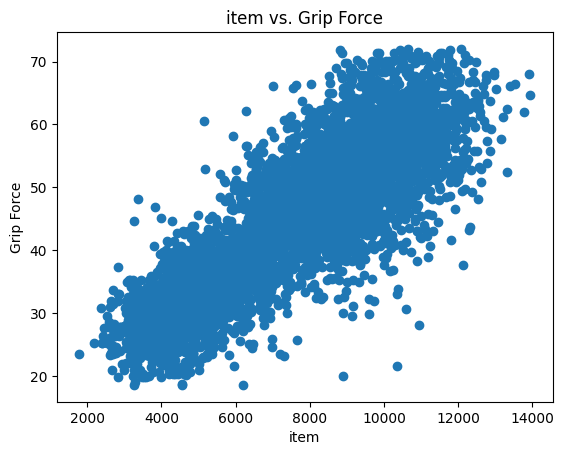

w_wb:[0.00155 0.00155], lwb:[8091.41246499  418.16407686], wb_grad:[-89.95227882 -20.44906054], y_pred:[0. 0. 0. ... 0. 0. 0.]

Iteration 0, Cost: 1081.747026566311, y:[27.4 43.9 31.2 ... 44.8 33.2 33.6], y_pred:[0. 0. 0. ... 0. 0. 0.], error:[27.4 43.9 31.2 ... 44.8 33.2 33.6]
w_wb:[0.02895265 0.02890239], lwb:[814210.23340046  41575.95201213], wb_grad:[-89.69309164 -20.19986342], y_pred:[ 0.01279018  0.06340022 -0.0061518  ...  0.10798511  0.01839192
 -0.02158356]

Iteration 100, Cost: 1078.6271610228962, y:[27.4 43.9 31.2 ... 44.8 33.2 33.6], y_pred:[ 0.01279018  0.06340022 -0.0061518  ...  0.10798511  0.01839192
 -0.02158356], error:[27.38720982 43.83659978 31.2061518  ... 44.69201489 33.18160808
 33.62158356]
w_wb:[0.04170974 0.04160744], lwb:[1617593.06707554   82141.60877577], wb_grad:[-89.57787367 -20.08935975], y_pred:[ 0.01852534  0.09158043 -0.00881298 ...  0.15592904  0.02660857
 -0.03108388]

Iteration 200, Cost: 1077.24557015915, y:[27.4 43.9 31.2 ... 44.8 33.2 33.6], y_p

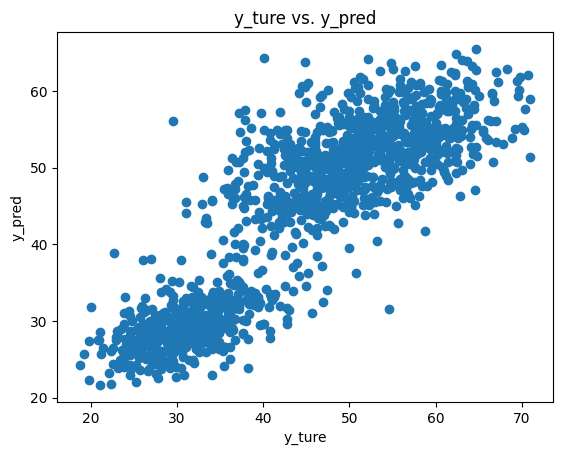

Mean Absolute Percentage Error (MAPE): 11.02%


In [66]:
# TODO

# (1) Split data
training_data, validation_data = SplitData_adv(training_datalist, 0.8)
# (2) Preprocess data
training_data = PreprocessData_adv(training_data)
validation_data = PreprocessData_adv(validation_data)
plot_data(training_data)
# (3) Train regression model
w_wb, w_height = Regression_adv(training_data)

# print(f"w_wb_1:{w_wb}")
# (4) Predict validation dataset's answer, calculate MAPE comparing to the ground truth
y_pred = MakePrediction_adv(w_wb, w_height, validation_data[:, :-1])
y_true = validation_data[:, -1]
print(f"y_pred:{y_pred}")
plot_pred(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
# (5) Make prediction of testing dataset and store the values in output_datalist
testing_datalist = test_pre(testing_datalist)
output_datalist = MakePrediction_adv(w_wb, w_height, testing_datalist[:, :])

In [51]:
# Assume that output_datalist is a list (or 1d array) with length = 100

with open(output_dataroot, 'w', newline='', encoding="utf-8") as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(['Id', 'gripForce'])
  for i in range(len(output_datalist)):
    writer.writerow([i,output_datalist[i]])


# Save the Code File
Please save your code and submit it as an ipynb file! (**Lab1.ipynb**)